In [2]:
import sys
sys.path.insert(0,'..')
import cocpit.plot as plot
import cocpit
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix
%load_ext autoreload
%autoreload 2

In [3]:
plt_params = {'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'legend.title_fontsize': 12}
plt.rcParams["font.family"] = "serif"
plt.rcParams.update(plt_params)

### plot confusion matrix on all validation dataloaders from cross fold validation

In [160]:
'''
iterate through each fold and append predictions and actual labels
changing saved model and validation data each time
'''
class_names = ['aggregates','budding',
              'bullets','columns','compact\n irregulars',
              'fragments','plates','rimed',
              'spheres']

all_preds = []
all_labels = []
for fold in kfold:
    val_data = torch.load('/data/data/saved_val_loaders/no_mask/val_loader20_bs64_k'+
                          fold+'_1models_vgg16_no_blank.pt')
    saved_model_name = '/data/data/saved_models/no_mask/e20_bs64_k'+fold+'_1models_vgg16_no_blank'
    
    model = torch.load(saved_model_name).cuda()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    result = saved_model_name.find('bs')
    batch_size = saved_model_name[result+2:result+4]

    #get predictions from val loader 
    preds, labels = cocpit.data_loaders.get_val_loader_predictions(model, val_data, device, batch_size)
    all_preds.append(preds)
    all_labels.append(labels)

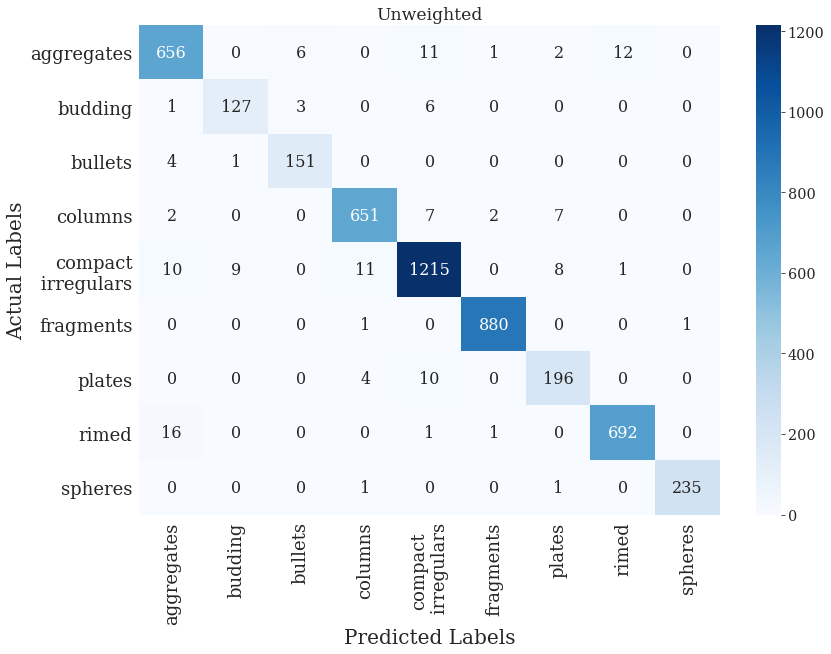

In [161]:
#plot/save conf matrix
save_name = '/data/data/plots/conf_matrix_allfolds.pdf'
cocpit.classification_metrics.plot_confusion_matrix(all_preds, all_labels,
                                                    class_names, norm=False,
                                                    save_name=save_name,
                                                    save_fig=True)

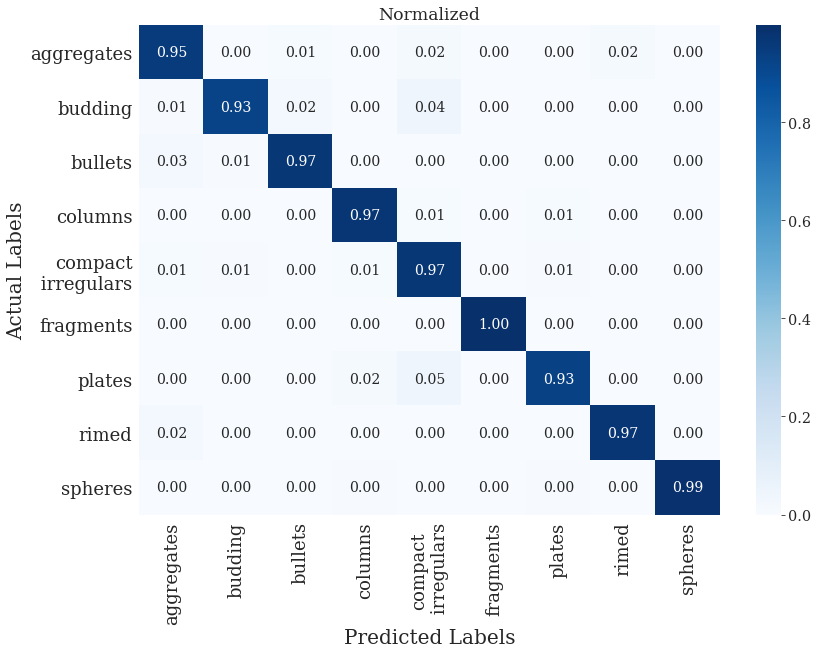

In [162]:
#plot/save normalized conf matrix
save_name = '/data/data/plots/norm_conf_matrix_allfolds.pdf'
cocpit.classification_metrics.plot_confusion_matrix(all_preds, all_labels,
                                                    class_names, norm=True,
                                                    save_name=save_name,
                                                    save_fig=True)

### classification reports

A macro-average will compute the metric independently for each class and then take the average (hence treating all classes equally), whereas a micro-average will aggregate the contributions of all classes to compute the average metric. In a multi-class classification setup, macro-average is preferable if you suspect there might be class imbalance (i.e you may have many more examples of one class than of other classes).

In [3]:
#rename models for plotting
model_names = ['efficient', 'resnet18', 'resnet34',
               'resnet152', 'alexnet', 'vgg16', 'vgg19',
               'densenet169', 'densenet201']
new_names = ['Efficient-b0', 'ResNet-18', 'ResNet-34',
               'ResNet-152', 'AlexNet', 'VGG-16', 'VGG-19',
               'DenseNet-169', 'DenseNet-201']
convert_names = {model_names[i]: new_names[i] for i in range(len(new_names))}
convert_names

{'efficient': 'Efficient-b0',
 'resnet18': 'ResNet-18',
 'resnet34': 'ResNet-34',
 'resnet152': 'ResNet-152',
 'alexnet': 'AlexNet',
 'vgg16': 'VGG-16',
 'vgg19': 'VGG-19',
 'densenet169': 'DenseNet-169',
 'densenet201': 'DenseNet-201'}

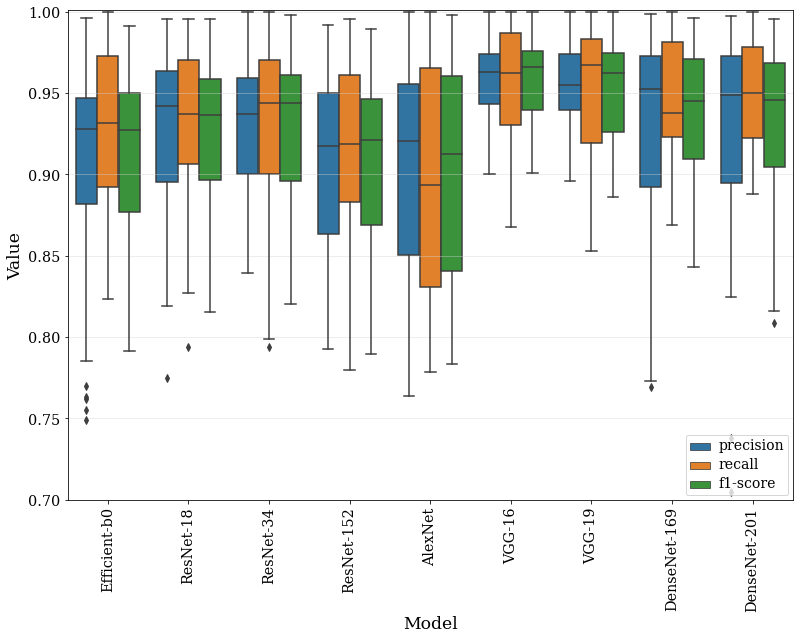

In [10]:
'''
classification report w.r.t. each model 
includes variability between classes and folds
'''
metric_filename = '/data/data/saved_accuracies/no_mask/save_val_metrics_e20_bs64_k5_9_no_blank.csv'
save_name = '/data/data/plots/model_metrics.pdf'
cocpit.classification_metrics.plot_model_metric_folds(metric_filename, convert_names, save_name,
                                                      plot_classes=True, save_fig=False)

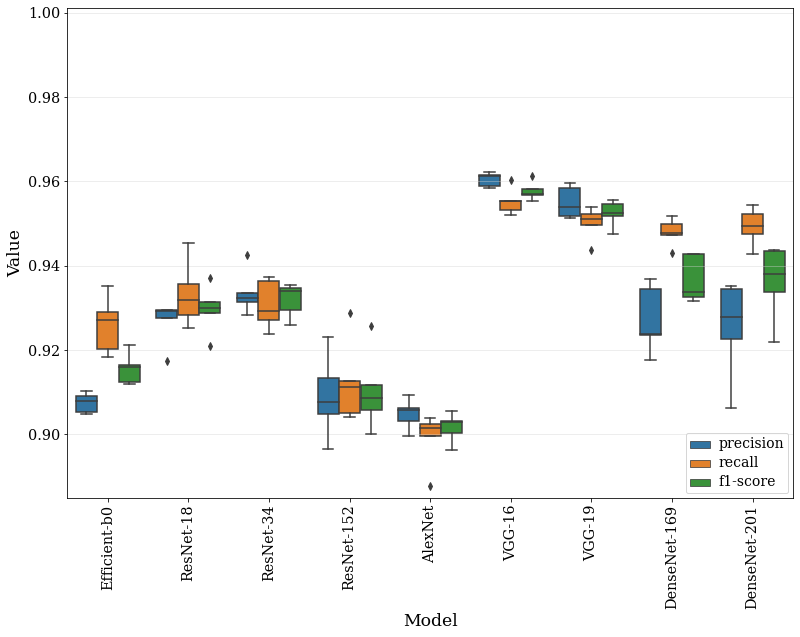

In [8]:
'''
classification report w.r.t. each model 
includes variability only between folds
plots the macro avg across classes
'''
metric_filename = '/data/data/saved_accuracies/no_mask/save_val_metrics_e20_bs64_k5_9_no_blank.csv'
save_name = '/data/data/plots/model_metrics.pdf'
cocpit.classification_metrics.plot_model_metric_folds(metric_filename, convert_names, save_name,
                                                      plot_classes=False, save_fig=False)

### plot precision, recall, and f1-score w.r.t. each class

In [7]:
'''
classification report for best overall performing model (vgg16) w.r.t class
'''
save_name='/data/data/plots/clf_report_classes_vgg16_all_folds.pdf'
clf_report = cocpit.classification_metrics.metrics_report(all_labels, all_preds, class_names)
cocpit.classification_metrics.plot_classification_report_classes(clf_report, save_name, save_fig=True)

NameError: name 'all_labels' is not defined

### plot batch size vs val acc for vgg16, 30 epochs

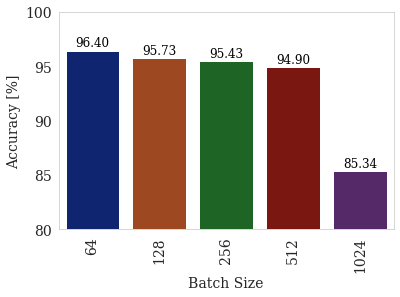

In [39]:
val_csv = '/data/data/saved_accuracies/no_mask/save_val_acc_loss_batchsize_compare_vgg16_k0_10classes.csv'
save_name = '/data/data/plots/batch_size_vs_val_acc.pdf'
plot.plot_batch_size_accuracy(val_csv, save_name, save_fig=False)

## plot training and validation accuracy and loss

In [167]:
train_csv = '/data/data/saved_accuracies/no_mask/save_train_acc_loss_e20_bs64_k5_9models_no_blank.csv' 
df_train = pd.read_csv(train_csv, names=["Model", "Epoch", "Kfold", "Batch Size", "Accuracy", "Loss"])

df_train.replace(convert_names, inplace=True)
df_train.head()

,Model,Epoch,Kfold,Batch Size,Accuracy,Loss
0,Efficient-b0,0,0,64,0.598796,1.244361
1,Efficient-b0,1,0,64,0.878086,0.337488
2,Efficient-b0,2,0,64,0.926851,0.210141
3,Efficient-b0,3,0,64,0.945569,0.160277
4,Efficient-b0,4,0,64,0.957608,0.132710


In [168]:
val_csv = '/data/data/saved_accuracies/no_mask/save_val_acc_loss_e20_bs64_k5_9models_no_blank.csv'
df_val = pd.read_csv(val_csv, names=["Model", "Epoch", "Kfold", "Batch Size", "Accuracy", "Loss"])
df_val.replace(convert_names, inplace=True)
df_val.head()

,Model,Epoch,Kfold,Batch Size,Accuracy,Loss
0,Efficient-b0,0,0,64,0.135141,3.007321
1,Efficient-b0,1,0,64,0.835525,0.479147
2,Efficient-b0,2,0,64,0.827837,0.461430
3,Efficient-b0,3,0,64,0.914424,0.230426
4,Efficient-b0,4,0,64,0.892575,0.272835


In [169]:
colors = {'Efficient-b0': '#C76114', 'ResNet-18': '#CAE1FF', 'ResNet-34': '#3063A5', 'ResNet-152': '#162252',
       'AlexNet': '#FCDC3B', 'VGG-16': '#CD9B9B', 'VGG-19': '#9E0508', 'DenseNet-169': '#9CBA7F',
       'DenseNet-201': '#006633'}
num_epochs = int(val_csv[55:57])
kfold = int(val_csv[64:65])
num_models = len(model_names)

In [170]:
#reshape data
if kfold == 0:
    val_accs = df_val['Accuracy'].values.reshape(num_models, num_epochs)
    val_losses = df_val['Loss'].values.reshape(num_models, num_epochs)
    train_accs = df_train['Accuracy'].values.reshape(num_models, num_epochs)
    train_losses = df_train['Loss'].values.reshape(num_models, num_epochs)
else:
    val_accs = np.average(df_val['Accuracy'].values.reshape(num_models, kfold, num_epochs), axis=1)
    val_losses = np.average(df_val['Loss'].values.reshape(num_models, kfold, num_epochs), axis=1)
    train_accs = np.average(df_train['Accuracy'].values.reshape(num_models, kfold, num_epochs), axis=1)
    train_losses = np.average(df_train['Loss'].values.reshape(num_models, kfold, num_epochs), axis=1)

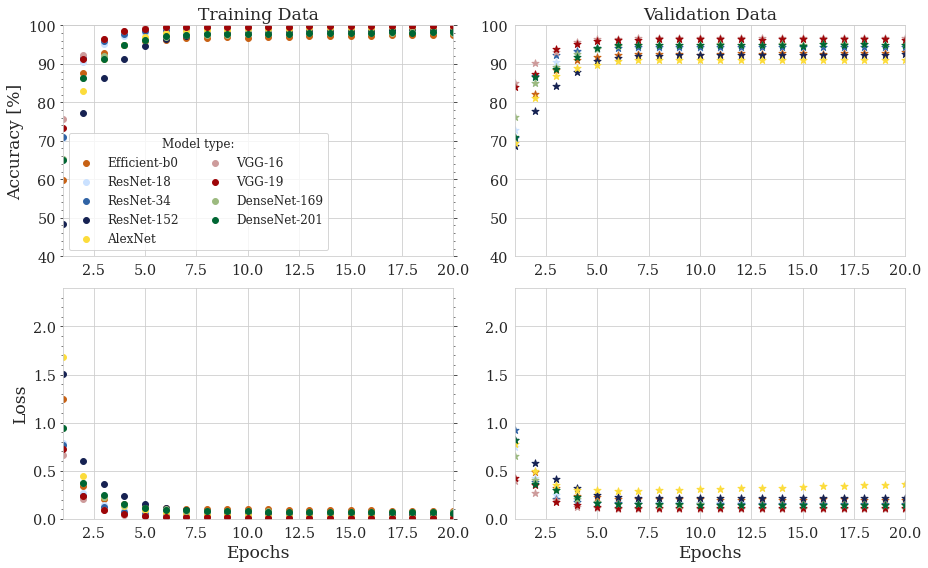

In [172]:
save_name = '/data/data/plots/loss_acc_9models_bs64_e20_10classes_avg5kfold_noblank.pdf' 
plot.plot_train_val_acc_loss(model_names, num_models, num_epochs, train_accs, colors, new_names,
                            val_accs, train_losses, val_losses, save_name, save_fig=True)

### plot time it takes to train different models

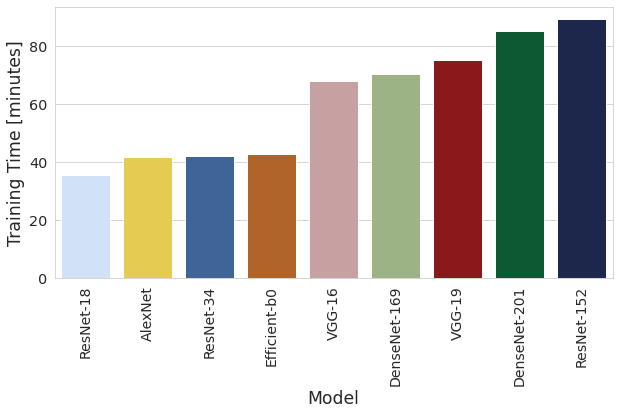

In [43]:
time_csv = '/data/data/saved_timings/model_timing2.csv'
save_name = '/data/data/plots/training_time.pdf'
plot.plot_model_timing(time_csv, convert_names, colors, save_name, save_fig=False)

### plot time it takes to run different samples

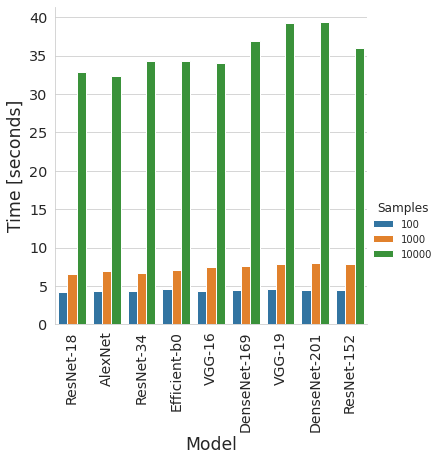

In [44]:
time_csv = '/data/data/saved_timings/model_timing_samples.csv'
save_name = '/data/data/plots/model_timing_samples.pdf'
plot.plot_time_samples(time_csv, save_name, convert_names, save_fig=False)

## plot cross validation

In [16]:
val_accs = df_val['Accuracy'].values.reshape(num_models, kfold, num_epochs)
val_accs_avg = np.average(df_val['Accuracy'].values.reshape(num_models, kfold, num_epochs), axis=1)

In [17]:
val_accs_avg = {new_names[i]: val_accs_avg[i,-1] for i in range(len(model_names))} 
val_accs_avg

{'Efficient-b0': 0.966847186249117,
 'ResNet-18': 0.9601130209559688,
 'ResNet-34': 0.9970331999058158,
 'ResNet-152': 0.9600188368259948,
 'AlexNet': 0.9182952672474688,
 'VGG-16': 0.9964680951259712,
 'VGG-19': 0.9974099364257123,
 'DenseNet-169': 0.9156110195432069,
 'DenseNet-201': 0.89385448551919}

In [18]:
val_accs_avg_sort = dict(sorted(val_accs_avg.items(), key=lambda x: x[1]))
val_accs_avg_sort

{'DenseNet-201': 0.89385448551919,
 'DenseNet-169': 0.9156110195432069,
 'AlexNet': 0.9182952672474688,
 'ResNet-152': 0.9600188368259948,
 'ResNet-18': 0.9601130209559688,
 'Efficient-b0': 0.966847186249117,
 'VGG-16': 0.9964680951259712,
 'ResNet-34': 0.9970331999058158,
 'VGG-19': 0.9974099364257123}

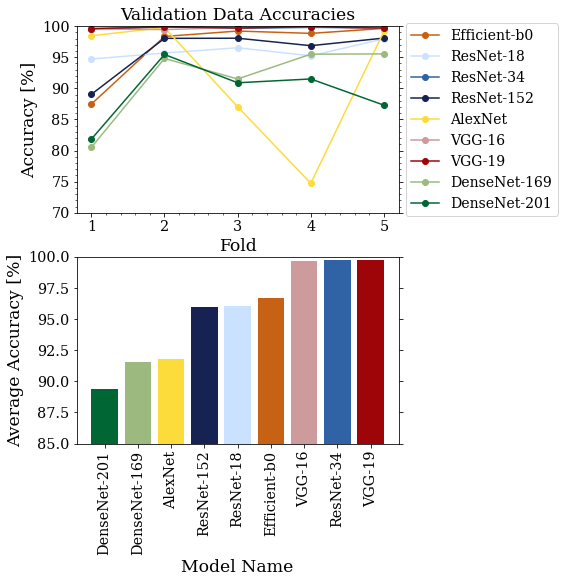

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7,7), sharex=True, sharey=True)
fig.tight_layout(pad=3.0)
#fig = plt.figure(figsize=(20,20))
ax1 = plt.subplot(2, 1, 1)

for i in range(num_models):
    ax1.plot(np.arange(1,(kfold+1)), [i*100 for i in val_accs[i,:,-1]],
                c=colors[new_names[i]], marker='o', label=new_names[i])
plt.ylabel("Accuracy [%]")
plt.xlabel("Fold")
plt.ylim(70,100)
#plt.xlim(1,num_epochs)
#ax1.legend(title='Model type:', loc='best', prop={'size': 12})
# Shrink current axis by 20%
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
ax1.axes.xaxis.set_ticks(np.arange(1,6,1))
ax1.yaxis.set_ticks_position('both')
ax1.minorticks_on()
ax1.tick_params(axis='y', which='minor', direction='out')
#ax1.xaxis.set_tick_params(which='minor', bottom=False)
ax1.title.set_text('Validation Data Accuracies')

ax2 = plt.subplot(2, 1, 2)
plt.bar(np.arange(1,num_models+1), [i*100 for i in val_accs_avg_sort.values()],
        color=sorted_colors.values())
plt.ylabel("Average Accuracy [%]")
plt.xlabel("Model Name")
plt.ylim(85,100)
#plt.xlim(1,num_epochs)
# Shrink current axis by 20%
box = ax2.get_position()
ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
# Set number of ticks for x-axis
ax2.set_xticks(np.arange(1,10))
# Set ticks labels for x-axis
ax2.set_xticklabels(sorted_colors.keys(), rotation='vertical')
ax2.yaxis.set_ticks_position('both')
